# Data preprocessing

In [1]:
import plotting
import util
import preprocessing

import numpy as np
import pandas as pd
from scipy import interpolate
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
plt.rc('xtick', labelsize=18)
plt.rc('ytick', labelsize=18)
plt.rc('axes', labelsize=20)
plt.rc('legend', fontsize=18)

from tqdm import tqdm
from skimage import filters, segmentation, feature, measure, morphology
from skimage.exposure import equalize_adapthist, rescale_intensity
from skimage.color import label2rgb
from skimage.io import imread, imsave

import scipy.ndimage as ndi

## Data and models directories

In [2]:
base_dir = 'D:/Santi/'
data_path = base_dir+'Data/' 
model_path = base_dir+'Models/' 
optimal_sigma_data_path = data_path + 'max_optimal_sigma_data/'

## Import input and output data

In [3]:
#Inputs
input_data = util.load_h5(data_path, 'Mito')
print('Inputs'+':', input_data.shape)

#Outputs
output_data = util.load_h5(data_path, 'Proc')
print('Outputs:', output_data.shape)


Loading D:/Santi/Data/Mito.h5
Converting to array
Inputs: (37000, 128, 128)

Loading D:/Santi/Data/Proc.h5
Converting to array
Outputs: (37000, 128, 128)


### Original stack labels

Create a GT for fission segmentation. This is used later to compare the results obtained using the orginal and preprocessed datasets

In [4]:
#labels = np.zeros(output_data.shape, dtype=np.uint8)
#for frame, output_img in tqdm(enumerate(output_data), total=output_data.shape[0]):
#  labels[frame] = preprocessing.distance_watershed(output_img*segmentation.clear_border(output_img>0), sigma=0)
#util.save_h5(labels, data_path, 'labels')

labels = util.load_h5(data_path, 'labels')
print('Labels:', labels.shape)


Loading D:/Santi/Data/labels.h5
Converting to array
Labels: (37000, 128, 128)


### Max probability of division is correlated with the mean probability of division

Max probability of division depends linearly on the mean output. Considering this and the fact that the max output dynamic range is bigger than the mean output one, the max probability of division could be a better readout for filtering fissions.

In [5]:
intensityStats = pd.DataFrame(columns=['max_intensity', 'mean_intensity'])

for frame in tqdm(range(output_data.shape[0]), total=output_data.shape[0]):
  newStats = pd.DataFrame(measure.regionprops_table(labels[frame], intensity_image=output_data[frame], properties = ['area', 'max_intensity', 'mean_intensity']))
  #Remove small fissions
  newStats = newStats[newStats['area']>9]
  intensityStats = pd.concat([intensityStats, newStats], ignore_index=True)
  
#Normalize max and mean data to 0-1 range.
intensityStats = (intensityStats[['max_intensity', 'mean_intensity']]/255).astype(np.float32)

100%|███████████████████████████████████████████████████████| 37000/37000 [01:20<00:00, 461.51it/s]


In [8]:
#Linear fit of max vs mean probability of division 
slope, offset = np.polyfit(intensityStats['max_intensity'], intensityStats['mean_intensity'], 1)

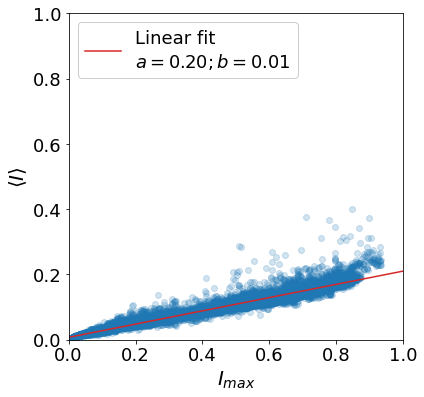

In [10]:
xticks = np.linspace(0, 1, 4, endpoint=True)

fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(intensityStats['max_intensity'], intensityStats['mean_intensity'], facecolor='tab:blue', alpha=0.2)
ax.plot(xticks, slope*xticks+offset, color='tab:red', label='Linear fit\n$a=%.2f; b=%.2f$'%(max_max_slope, max_max_offset))

ax.set(ylabel=r'$\leftangle I \rightangle$', xlabel=r'$I_{{max}}$', xlim=[0, 1], ylim=[0, 1])
ax.legend(loc='upper left', framealpha=1)
plt.show()

## GT preprocessing
### Filter events by mean probability of division and replace each fission by a gaussian disk
Original GT prepared by Dr. Dora Mahecic includes all of the events that might be fissions:

D:/Santi/Figures/ground_truth_t00025.pdf


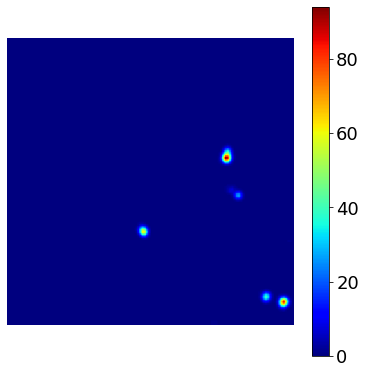

In [94]:
item_id = 25
img = output_data[item_id]
cmap = 'jet'
title = 'ground_truth'
filename = base_dir+'Figures/'+title+'_t{:05}.pdf'.format(item_id)
print(filename)

fig, ax = plt.subplots(figsize=(5, 5))
#ax.set_title(title.title(), size=20)
im_ax = ax.imshow(img, cmap=cmap)
fig.colorbar(im_ax)
ax.axis('off')
plt.tight_layout(pad=0)
plt.show()
#plt.savefig(filename)

However, not all of the detected areas included in the GT correspond to true mitochondrial contriction sites. To filter this GT:

1. Remove events that are in contact with the border of the image.
2. Calculate the Distance Map by measuring the distance from local maxima to the border of the object

D:/Santi/Figures/distance_map_t00025.pdf


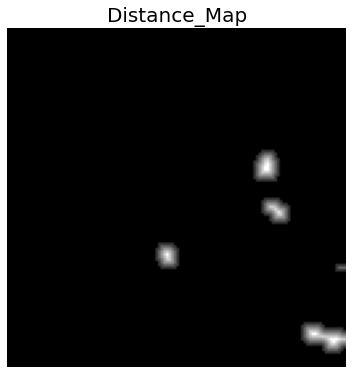

In [95]:
sigma = 2
mask = segmentation.clear_border(img>0)
img_proc = img*mask
distance = ndi.distance_transform_edt(filters.gaussian(img_proc, sigma/10))

cmap = 'gray'
title = 'distance_map'
filename = base_dir+'Figures/'+title+'_t{:05}.pdf'.format(item_id)
print(filename)

fig, ax = plt.subplots(figsize=(5, 5))
ax.set_title(title.title(), size=20)
ax.imshow(distance, cmap=cmap)
ax.axis('off')
plt.tight_layout(pad=0)
#plt.show()
plt.savefig(filename)

3. Segment fissions by using Distance Map as the input intensity image and local maxima as markers to implement the Watershed algorithm

D:/Santi/Figures/watershed_t00025.pdf


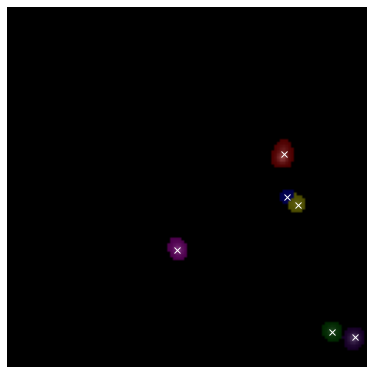

In [96]:
labels = preprocessing.distance_watershed(img_proc, sigma=sigma/10)
labels = morphology.remove_small_objects(labels, 9) #Remove too small objects

rp = measure.regionprops_table(labels, intensity_image=img_proc, properties=['weighted_centroid'])
centroids = np.array([rp['weighted_centroid-0'], rp['weighted_centroid-1']]).round().astype(int)

title = 'watershed'
filename = base_dir+'Figures/'+title+'_t{:05}.pdf'.format(item_id)
print(filename)
alpha=0.3

fig, ax = plt.subplots(figsize=(5, 5))
#ax.set_title(title.title(), size=20)
ax.imshow(label2rgb(labels, image=img_proc, alpha=alpha, bg_label=0))
ax.plot(centroids[1], centroids[0], 'x', markersize=6, color='white')
ax.axis('off')
plt.tight_layout(pad=0)
#plt.show()
plt.savefig(filename)

D:/Santi/Figures/proc_output_data_t00025.pdf


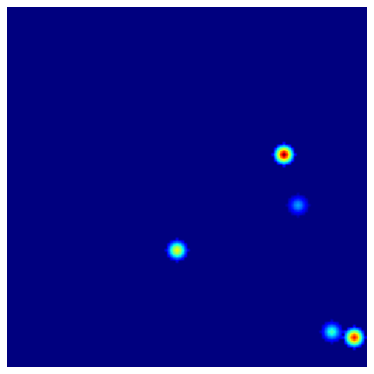

In [97]:
img_proc, fission_props = preprocessing.prepareProc(output_data[item_id], sigma=sigma, threshold=10, mode='max')

title = 'proc_output_data'
filename = base_dir+'Figures/'+title+'_t{:05}.pdf'.format(item_id)
print(filename)

fig, ax = plt.subplots(figsize=(5, 5))
#ax.set_title(title.title(), size=20)
ax.imshow(img_proc, cmap='jet')
ax.axis('off')
plt.tight_layout(pad=0)
#plt.show()
plt.savefig(filename)

D:/Santi/Figures/proc_labels_t00025.pdf


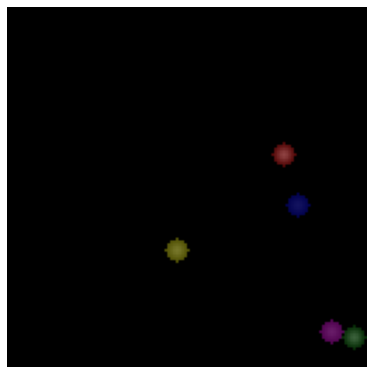

In [98]:
proc_labels = preprocessing.segmentFissions(img_proc, fission_props, 0)

title = 'proc_labels'
filename = base_dir+'Figures/'+title+'_t{:05}.pdf'.format(item_id)
print(filename)

fig, ax = plt.subplots(figsize=(5, 5))
#ax.set_title(title.title(), size=20)
ax.imshow(label2rgb(proc_labels, image=img_proc, alpha=alpha, bg_label=0), cmap='jet')
ax.axis('off')
plt.tight_layout(pad=0)
#plt.show()
plt.savefig(filename)

4. Calculate max (or mean) intensity per fission and remove those below a given **threshold**.
5. Gaussian dilation (**sigma** is an input) of mask generated from fission centroids 
6. Choose a **number of sigmas** to cut the gaussian dilation at a radius equal to round(dilation_nb_sigmas*sigma).
7. Rescale intensity so there is a smooth transition between the background and fission intensities.

#### Threshold estimation

##### Mean

In [67]:
#Estimate thresholds from mean and std intensity 
#mean_intensity = output_data[output_data!=0].mean()
#std_intensity = output_data[output_data!=0].std()
#weigth = np.array([-0.5, -0.25, -0.1, 0, 0.1, 0.5, 1])

#threshold = mean_intensity + weigth*std_intensity
#util.save_pkl(threshold, data_path, 'mean_intensity_threshold')

threshold = util.load_pkl(data_path, 'mean_intensity_threshold')


Loading H:/Santi/Data/mean_intensity_threshold


##### Max

In [39]:
#Estimate thresholds for max intensity 
#max_intensity = output_data.max(axis=1).max(axis=1)

#percentile = np.arange(0, 101, 1)
#threshold = np.percentile(max_intensity, percentile)
#first_non_zero_perc = np.where(threshold!=0)[0][0]

#percentile = np.arange(first_non_zero_perc, 80, 7)
#threshold = np.percentile(max_intensity, percentile).astype(np.uint8)

#util.save_pkl(threshold, data_path, 'max_intensity_threshold')

threshold = util.load_pkl(data_path, 'max_intensity_threshold')


Loading D:/Santi/Data/max_intensity_threshold


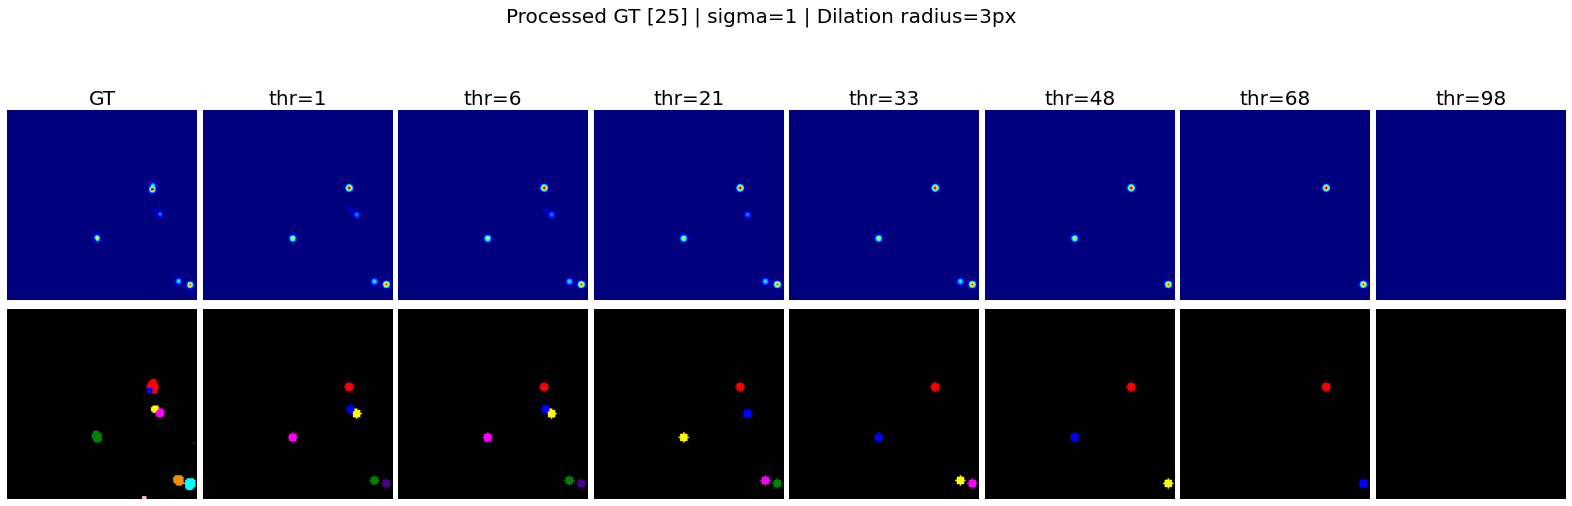

In [110]:
sigma = 1.5
dilation_nb_sigmas = 2

nb_cols = len(threshold)+1
title_size = 20
cmap = 'jet'
frame = 25
labels = preprocessing.distance_watershed(output_data[frame], sigma=0)

fig, axes = plt.subplots(2, nb_cols, figsize=(nb_cols*3.5, 2*4))
for thr, ax_img, ax_labels in zip(threshold, axes[0, 1:], axes[1, 1:]):
  img_proc, fission_props = preprocessing.prepareProc(output_data[frame], sigma=sigma, dilation_nb_sigmas=dilation_nb_sigmas, 
                                                      threshold=thr, mode='max')
  new_labels = preprocessing.segmentFissions(img_proc, fission_props, 0)
  ax_img.set_title('thr=%.i'%thr, size=title_size)
  ax_img.imshow(img_proc, cmap=cmap)
  ax_img.axis('off')
  
  ax_labels.imshow(label2rgb(new_labels, bg_label=0)) 
  ax_labels.axis('off')

axes[1, 0].imshow(label2rgb(labels, bg_label=0))
axes[0, 0].set_title('GT', size=title_size)
axes[0, 0].imshow(output_data[frame], cmap=cmap)
axes[0, 0].axis('off')
axes[1, 0].axis('off')
  
fig.suptitle('Processed GT [%i] | sigma=%i | Dilation radius=%ipx'%(frame, sigma, round(dilation_nb_sigmas*sigma)), size=title_size)
fig.subplots_adjust(wspace=0.01, hspace=0.05, top=0.8)
plt.show()

#### How to choose the sigma of the gaussian dilation

##### Preprocess GT using different minimum spot sizes and mean intensity thresholds

In [42]:
sigmas = np.array([1.5, 2, 2.5, 3])
dilation_nb_sigmas = 2

threshold = util.load_pkl(data_path, 'max_intensity_threshold')

#Choose 1000 random images to reduce the amount of data used to estimate optimal sigma
indices = np.sort(np.random.choice(output_data.shape[0], 1000, replace=False))
util.save_pkl(indices, optimal_sigma_data_path, 'indices')

optimal_sigma_output_data = output_data[indices]
for s in sigmas:
  for thr in threshold:
    print('\nSigma: %.1f | Threshold: %.1f'%(s, thr))
    proc_output_data, fission_props = preprocessing.prepareStack(optimal_sigma_output_data, sigma=s, 
                                                                 dilation_nb_sigmas=dilation_nb_sigmas, threshold=thr)
    proc_labels = preprocessing.segmentFissionsStack(proc_output_data, fission_props)
    util.save_h5(proc_output_data, optimal_sigma_data_path, 'WatProc_s%.1f_t%i'%(s, thr))
    util.save_h5(proc_labels, optimal_sigma_data_path, 'proc_labels_s%.1f_t%i'%(s, thr))
    util.save_pkl(fission_props, optimal_sigma_data_path, 'fission_props_s%.1f_t%i'%(s, thr))


Loading D:/Santi/Data/max_intensity_threshold

Saving D:/Santi/Data/max_optimal_sigma_data/indices
Done.

Sigma: 1.5 | Threshold: 1.0


  0%|                                                                     | 0/1000 [00:00<?, ?it/s]C:\Users\snrodrig\Documents\GitHub\MitoSplit-Net\mitosplit-net\preprocessing.py:115: UserWarning: Only one label was provided to `remove_small_objects`. Did you mean to use a boolean array?
  labels = morphology.remove_small_objects(labels, 9) #Remove too small objects
100%|█████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 728.62it/s]



Saving D:/Santi/Data/max_optimal_sigma_data/WatProc_s1.5_t1.h5
Done.

Saving D:/Santi/Data/max_optimal_sigma_data/proc_labels_s1.5_t1.h5
Done.

Saving D:/Santi/Data/max_optimal_sigma_data/fission_props_s1.5_t1
Done.

Sigma: 1.5 | Threshold: 6.0


100%|█████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 796.27it/s]



Saving D:/Santi/Data/max_optimal_sigma_data/WatProc_s1.5_t6.h5
Done.

Saving D:/Santi/Data/max_optimal_sigma_data/proc_labels_s1.5_t6.h5
Done.

Saving D:/Santi/Data/max_optimal_sigma_data/fission_props_s1.5_t6
Done.

Sigma: 1.5 | Threshold: 21.0


100%|█████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 907.69it/s]



Saving D:/Santi/Data/max_optimal_sigma_data/WatProc_s1.5_t21.h5
Done.

Saving D:/Santi/Data/max_optimal_sigma_data/proc_labels_s1.5_t21.h5
Done.

Saving D:/Santi/Data/max_optimal_sigma_data/fission_props_s1.5_t21
Done.

Sigma: 1.5 | Threshold: 33.0


100%|████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1076.95it/s]



Saving D:/Santi/Data/max_optimal_sigma_data/WatProc_s1.5_t33.h5
Done.

Saving D:/Santi/Data/max_optimal_sigma_data/proc_labels_s1.5_t33.h5
Done.

Saving D:/Santi/Data/max_optimal_sigma_data/fission_props_s1.5_t33
Done.

Sigma: 1.5 | Threshold: 48.0


100%|████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1261.69it/s]



Saving D:/Santi/Data/max_optimal_sigma_data/WatProc_s1.5_t48.h5
Done.

Saving D:/Santi/Data/max_optimal_sigma_data/proc_labels_s1.5_t48.h5
Done.

Saving D:/Santi/Data/max_optimal_sigma_data/fission_props_s1.5_t48
Done.

Sigma: 1.5 | Threshold: 68.0


100%|████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1578.69it/s]



Saving D:/Santi/Data/max_optimal_sigma_data/WatProc_s1.5_t68.h5
Done.

Saving D:/Santi/Data/max_optimal_sigma_data/proc_labels_s1.5_t68.h5
Done.

Saving D:/Santi/Data/max_optimal_sigma_data/fission_props_s1.5_t68
Done.

Sigma: 1.5 | Threshold: 98.0


100%|████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1993.10it/s]



Saving D:/Santi/Data/max_optimal_sigma_data/WatProc_s1.5_t98.h5
Done.

Saving D:/Santi/Data/max_optimal_sigma_data/proc_labels_s1.5_t98.h5
Done.

Saving D:/Santi/Data/max_optimal_sigma_data/fission_props_s1.5_t98
Done.

Sigma: 2.0 | Threshold: 1.0


100%|█████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 726.75it/s]



Saving D:/Santi/Data/max_optimal_sigma_data/WatProc_s2.0_t1.h5
Done.

Saving D:/Santi/Data/max_optimal_sigma_data/proc_labels_s2.0_t1.h5
Done.

Saving D:/Santi/Data/max_optimal_sigma_data/fission_props_s2.0_t1
Done.

Sigma: 2.0 | Threshold: 6.0


100%|█████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 782.36it/s]



Saving D:/Santi/Data/max_optimal_sigma_data/WatProc_s2.0_t6.h5
Done.

Saving D:/Santi/Data/max_optimal_sigma_data/proc_labels_s2.0_t6.h5
Done.

Saving D:/Santi/Data/max_optimal_sigma_data/fission_props_s2.0_t6
Done.

Sigma: 2.0 | Threshold: 21.0


100%|█████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 910.14it/s]



Saving D:/Santi/Data/max_optimal_sigma_data/WatProc_s2.0_t21.h5
Done.

Saving D:/Santi/Data/max_optimal_sigma_data/proc_labels_s2.0_t21.h5
Done.

Saving D:/Santi/Data/max_optimal_sigma_data/fission_props_s2.0_t21
Done.

Sigma: 2.0 | Threshold: 33.0


100%|████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1042.47it/s]



Saving D:/Santi/Data/max_optimal_sigma_data/WatProc_s2.0_t33.h5
Done.

Saving D:/Santi/Data/max_optimal_sigma_data/proc_labels_s2.0_t33.h5
Done.

Saving D:/Santi/Data/max_optimal_sigma_data/fission_props_s2.0_t33
Done.

Sigma: 2.0 | Threshold: 48.0


100%|████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1239.68it/s]



Saving D:/Santi/Data/max_optimal_sigma_data/WatProc_s2.0_t48.h5
Done.

Saving D:/Santi/Data/max_optimal_sigma_data/proc_labels_s2.0_t48.h5
Done.

Saving D:/Santi/Data/max_optimal_sigma_data/fission_props_s2.0_t48
Done.

Sigma: 2.0 | Threshold: 68.0


100%|████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1536.54it/s]



Saving D:/Santi/Data/max_optimal_sigma_data/WatProc_s2.0_t68.h5
Done.

Saving D:/Santi/Data/max_optimal_sigma_data/proc_labels_s2.0_t68.h5
Done.

Saving D:/Santi/Data/max_optimal_sigma_data/fission_props_s2.0_t68
Done.

Sigma: 2.0 | Threshold: 98.0


100%|████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1999.90it/s]



Saving D:/Santi/Data/max_optimal_sigma_data/WatProc_s2.0_t98.h5
Done.

Saving D:/Santi/Data/max_optimal_sigma_data/proc_labels_s2.0_t98.h5
Done.

Saving D:/Santi/Data/max_optimal_sigma_data/fission_props_s2.0_t98
Done.

Sigma: 2.5 | Threshold: 1.0


100%|█████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 719.54it/s]



Saving D:/Santi/Data/max_optimal_sigma_data/WatProc_s2.5_t1.h5
Done.

Saving D:/Santi/Data/max_optimal_sigma_data/proc_labels_s2.5_t1.h5
Done.

Saving D:/Santi/Data/max_optimal_sigma_data/fission_props_s2.5_t1
Done.

Sigma: 2.5 | Threshold: 6.0


100%|█████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 797.97it/s]



Saving D:/Santi/Data/max_optimal_sigma_data/WatProc_s2.5_t6.h5
Done.

Saving D:/Santi/Data/max_optimal_sigma_data/proc_labels_s2.5_t6.h5
Done.

Saving D:/Santi/Data/max_optimal_sigma_data/fission_props_s2.5_t6
Done.

Sigma: 2.5 | Threshold: 21.0


100%|█████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 892.01it/s]



Saving D:/Santi/Data/max_optimal_sigma_data/WatProc_s2.5_t21.h5
Done.

Saving D:/Santi/Data/max_optimal_sigma_data/proc_labels_s2.5_t21.h5
Done.

Saving D:/Santi/Data/max_optimal_sigma_data/fission_props_s2.5_t21
Done.

Sigma: 2.5 | Threshold: 33.0


100%|████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1061.30it/s]



Saving D:/Santi/Data/max_optimal_sigma_data/WatProc_s2.5_t33.h5
Done.

Saving D:/Santi/Data/max_optimal_sigma_data/proc_labels_s2.5_t33.h5
Done.

Saving D:/Santi/Data/max_optimal_sigma_data/fission_props_s2.5_t33
Done.

Sigma: 2.5 | Threshold: 48.0


100%|████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1249.37it/s]



Saving D:/Santi/Data/max_optimal_sigma_data/WatProc_s2.5_t48.h5
Done.

Saving D:/Santi/Data/max_optimal_sigma_data/proc_labels_s2.5_t48.h5
Done.

Saving D:/Santi/Data/max_optimal_sigma_data/fission_props_s2.5_t48
Done.

Sigma: 2.5 | Threshold: 68.0


100%|████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1576.37it/s]



Saving D:/Santi/Data/max_optimal_sigma_data/WatProc_s2.5_t68.h5
Done.

Saving D:/Santi/Data/max_optimal_sigma_data/proc_labels_s2.5_t68.h5
Done.

Saving D:/Santi/Data/max_optimal_sigma_data/fission_props_s2.5_t68
Done.

Sigma: 2.5 | Threshold: 98.0


100%|████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1852.74it/s]



Saving D:/Santi/Data/max_optimal_sigma_data/WatProc_s2.5_t98.h5
Done.

Saving D:/Santi/Data/max_optimal_sigma_data/proc_labels_s2.5_t98.h5
Done.

Saving D:/Santi/Data/max_optimal_sigma_data/fission_props_s2.5_t98
Done.

Sigma: 3.0 | Threshold: 1.0


100%|█████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 746.57it/s]



Saving D:/Santi/Data/max_optimal_sigma_data/WatProc_s3.0_t1.h5
Done.

Saving D:/Santi/Data/max_optimal_sigma_data/proc_labels_s3.0_t1.h5
Done.

Saving D:/Santi/Data/max_optimal_sigma_data/fission_props_s3.0_t1
Done.

Sigma: 3.0 | Threshold: 6.0


100%|█████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 806.05it/s]



Saving D:/Santi/Data/max_optimal_sigma_data/WatProc_s3.0_t6.h5
Done.

Saving D:/Santi/Data/max_optimal_sigma_data/proc_labels_s3.0_t6.h5
Done.

Saving D:/Santi/Data/max_optimal_sigma_data/fission_props_s3.0_t6
Done.

Sigma: 3.0 | Threshold: 21.0


100%|█████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 901.20it/s]



Saving D:/Santi/Data/max_optimal_sigma_data/WatProc_s3.0_t21.h5
Done.

Saving D:/Santi/Data/max_optimal_sigma_data/proc_labels_s3.0_t21.h5
Done.

Saving D:/Santi/Data/max_optimal_sigma_data/fission_props_s3.0_t21
Done.

Sigma: 3.0 | Threshold: 33.0


100%|████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1076.91it/s]



Saving D:/Santi/Data/max_optimal_sigma_data/WatProc_s3.0_t33.h5
Done.

Saving D:/Santi/Data/max_optimal_sigma_data/proc_labels_s3.0_t33.h5
Done.

Saving D:/Santi/Data/max_optimal_sigma_data/fission_props_s3.0_t33
Done.

Sigma: 3.0 | Threshold: 48.0


100%|████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1260.44it/s]



Saving D:/Santi/Data/max_optimal_sigma_data/WatProc_s3.0_t48.h5
Done.

Saving D:/Santi/Data/max_optimal_sigma_data/proc_labels_s3.0_t48.h5
Done.

Saving D:/Santi/Data/max_optimal_sigma_data/fission_props_s3.0_t48
Done.

Sigma: 3.0 | Threshold: 68.0


100%|████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1557.90it/s]



Saving D:/Santi/Data/max_optimal_sigma_data/WatProc_s3.0_t68.h5
Done.

Saving D:/Santi/Data/max_optimal_sigma_data/proc_labels_s3.0_t68.h5
Done.

Saving D:/Santi/Data/max_optimal_sigma_data/fission_props_s3.0_t68
Done.

Sigma: 3.0 | Threshold: 98.0


100%|████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1891.98it/s]



Saving D:/Santi/Data/max_optimal_sigma_data/WatProc_s3.0_t98.h5
Done.

Saving D:/Santi/Data/max_optimal_sigma_data/proc_labels_s3.0_t98.h5
Done.

Saving D:/Santi/Data/max_optimal_sigma_data/fission_props_s3.0_t98
Done.


In [44]:
util.save_pkl(sigmas, data_path, 'sigmas')


Saving D:/Santi/Data/sigmas
Done.


##### How to choose the optimal sigma for gaussian dilation given a mean intensity threshold

In this section, we compare the mean diameter of all fissions in the GT to the one calculated from the different preprocessed outputs.

1) Load sigmas used  and thresholds used in the previous stage of the preprocessing

In [100]:
sigmas = util.load_pkl(data_path, 'sigmas')
threshold = util.load_pkl(data_path, 'max_intensity_threshold')
nb_sigmas = sigmas.shape[0]
nb_thresholds = threshold.shape[0]
#indices = util.load_pkl(optimal_sigma_data_path, 'indices')

fission_props_filename, proc_output_data_filename, proc_labels_filename = [], [], []
for s in sigmas:
  for t in threshold:
    fission_props_filename += ['fission_props_s%.1f_t%i'%(s, t)]
    proc_output_data_filename += ['WatProc_s%.1f_t%i'%(s, t)]
    proc_labels_filename += ['proc_labels_s%.1f_t%i'%(s, t)]
    
fission_props = util.load_pkl(optimal_sigma_data_path, fission_props_filename, as_type=np.ndarray)
proc_output_data = util.load_h5(optimal_sigma_data_path, proc_output_data_filename)
proc_labels = util.load_h5(optimal_sigma_data_path, proc_labels_filename)


Loading D:/Santi/Data/sigmas

Loading D:/Santi/Data/max_intensity_threshold

Loading D:/Santi/Data/max_optimal_sigma_data/fission_props_s1.5_t1

Loading D:/Santi/Data/max_optimal_sigma_data/fission_props_s1.5_t6

Loading D:/Santi/Data/max_optimal_sigma_data/fission_props_s1.5_t21

Loading D:/Santi/Data/max_optimal_sigma_data/fission_props_s1.5_t33

Loading D:/Santi/Data/max_optimal_sigma_data/fission_props_s1.5_t48

Loading D:/Santi/Data/max_optimal_sigma_data/fission_props_s1.5_t68

Loading D:/Santi/Data/max_optimal_sigma_data/fission_props_s1.5_t98

Loading D:/Santi/Data/max_optimal_sigma_data/fission_props_s2.0_t1

Loading D:/Santi/Data/max_optimal_sigma_data/fission_props_s2.0_t6

Loading D:/Santi/Data/max_optimal_sigma_data/fission_props_s2.0_t21

Loading D:/Santi/Data/max_optimal_sigma_data/fission_props_s2.0_t33

Loading D:/Santi/Data/max_optimal_sigma_data/fission_props_s2.0_t48

Loading D:/Santi/Data/max_optimal_sigma_data/fission_props_s2.0_t68

Loading D:/Santi/Data/max_opt

D:/Santi/Figures/optimal_sigma_proc_output_data_t00037.pdf


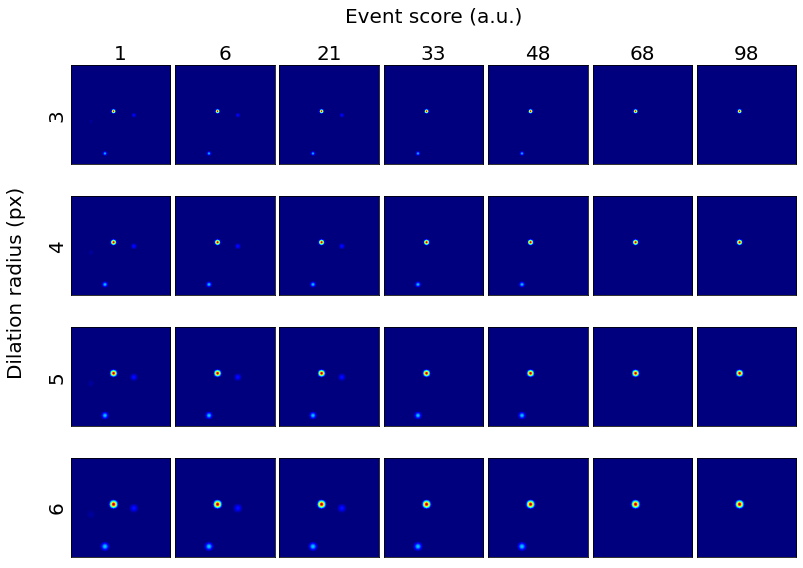

In [108]:
item_id = 37
nb_sigmas_threshold_ratio = 0.8*nb_sigmas/nb_thresholds
space = 0.05
width = 3
title_size = 20
cmap = 'jet'

title = 'optimal_sigma_proc_output_data'
filename = base_dir+'Figures/'+title+'_t{:05}.pdf'.format(item_id)
print(filename)

fig, axes = plt.subplots(nb_sigmas, nb_thresholds, figsize=(width*nb_sigmas*(1+space), width*nb_thresholds*(nb_sigmas_threshold_ratio+space)))
#fig.suptitle('proc_output_data [%i]'%indices[item_id], size=title_size)

for s_id in range(nb_sigmas):
  for t_id in range(nb_thresholds):
    axes[s_id, t_id].imshow(proc_output_data[t_id+s_id*nb_thresholds][item_id], cmap=cmap, aspect='equal')
    axes[s_id, t_id].set(xticks=[], yticks=[])
    
for t_id in range(nb_thresholds):
  axes[0, t_id].set_title('%.i'%threshold[t_id], size=title_size)
  
for s_id in range(nb_sigmas):
  axes[s_id, 0].set_ylabel('%.i'%(round(sigmas[s_id]*2)), size=title_size)
  
fig.text(0.5, 0.84, 'Event score (a.u.)', fontsize=title_size, ha='center')
fig.text(0.03, 0.5, 'Dilation radius (px)', fontsize=title_size, va='center', rotation=90)
fig.subplots_adjust(hspace=space, wspace=space, top=0.8, left=0.1)
plt.show()
#plt.savefig(filename)

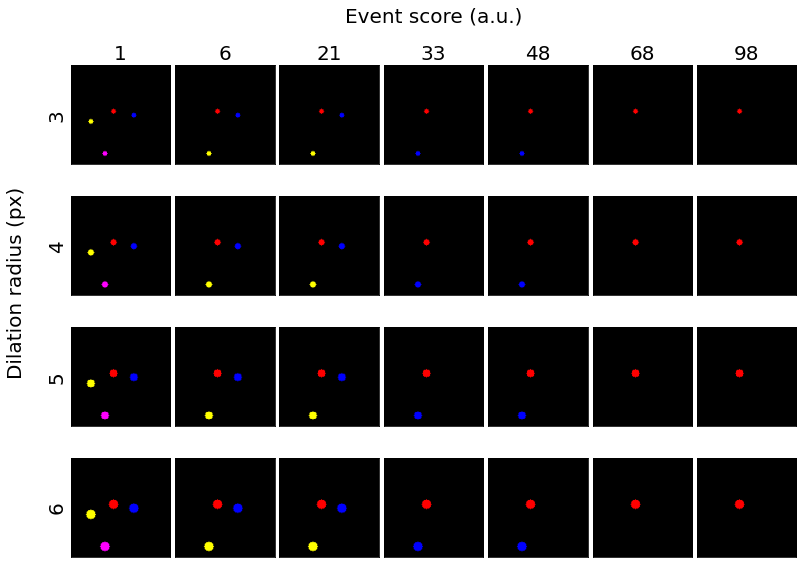

In [109]:
nb_sigmas_threshold_ratio = 0.8*nb_sigmas/nb_thresholds
space = 0.05
width = 3
title_size = 20
cmap = 'jet'

fig, axes = plt.subplots(nb_sigmas, nb_thresholds, figsize=(width*nb_sigmas*(1+space), width*nb_thresholds*(nb_sigmas_threshold_ratio+space)))
#fig.suptitle('proc_labels [%i]'%indices[item_id], size=title_size)

for s_id in range(nb_sigmas):
  for t_id in range(nb_thresholds):
    axes[s_id, t_id].imshow(label2rgb(proc_labels[t_id+s_id*nb_thresholds][item_id], bg_label=0))
    axes[s_id, t_id].set(xticks=[], yticks=[])
    
for t_id in range(nb_thresholds):
  axes[0, t_id].set_title('%.i'%threshold[t_id], size=title_size)
  
for s_id in range(nb_sigmas):
  axes[s_id, 0].set_ylabel('%.i'%(sigmas[s_id]*2), size=title_size)
  
fig.text(0.5, 0.84, 'Event score (a.u.)', fontsize=title_size, ha='center')
fig.text(0.03, 0.5, 'Dilation radius (px)', fontsize=title_size, va='center', rotation=90)
fig.subplots_adjust(hspace=space, wspace=space, top=0.8, left=0.1)
plt.show()

2) Calculate properties of outputs (GT was already analyzed before. See files 'fission_props_*')

In [78]:
proc_fission_props = []
print('Getting properties...')
for i in range(proc_output_data.shape[0]):
    print('\n'+proc_labels_filename[i])
    props = preprocessing.analyzeFissionsStack(proc_labels[i], proc_output_data[i])
    proc_fission_props += [props] 
    util.save_pkl(props, optimal_sigma_data_path, 'proc_fission_props_s%s'%proc_labels_filename[i].split('_s')[-1],)

Getting properties...

proc_labels_s1.5_t1


100%|████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 2987.35it/s]



Saving D:/Santi/Data/max_optimal_sigma_data/proc_fission_props_s1.5_t1
Done.

proc_labels_s1.5_t6


100%|████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 3568.98it/s]



Saving D:/Santi/Data/max_optimal_sigma_data/proc_fission_props_s1.5_t6
Done.

proc_labels_s1.5_t21


100%|████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 4126.79it/s]



Saving D:/Santi/Data/max_optimal_sigma_data/proc_fission_props_s1.5_t21
Done.

proc_labels_s1.5_t33


100%|████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 5104.26it/s]



Saving D:/Santi/Data/max_optimal_sigma_data/proc_fission_props_s1.5_t33
Done.

proc_labels_s1.5_t48


100%|████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 5776.18it/s]



Saving D:/Santi/Data/max_optimal_sigma_data/proc_fission_props_s1.5_t48
Done.

proc_labels_s1.5_t68


100%|████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 6987.97it/s]



Saving D:/Santi/Data/max_optimal_sigma_data/proc_fission_props_s1.5_t68
Done.

proc_labels_s1.5_t98


100%|████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 8397.27it/s]



Saving D:/Santi/Data/max_optimal_sigma_data/proc_fission_props_s1.5_t98
Done.

proc_labels_s2.0_t1


100%|████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 3233.92it/s]



Saving D:/Santi/Data/max_optimal_sigma_data/proc_fission_props_s2.0_t1
Done.

proc_labels_s2.0_t6


100%|████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 3398.92it/s]



Saving D:/Santi/Data/max_optimal_sigma_data/proc_fission_props_s2.0_t6
Done.

proc_labels_s2.0_t21


100%|████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 3972.77it/s]



Saving D:/Santi/Data/max_optimal_sigma_data/proc_fission_props_s2.0_t21
Done.

proc_labels_s2.0_t33


100%|████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 4922.98it/s]



Saving D:/Santi/Data/max_optimal_sigma_data/proc_fission_props_s2.0_t33
Done.

proc_labels_s2.0_t48


100%|████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 5818.08it/s]



Saving D:/Santi/Data/max_optimal_sigma_data/proc_fission_props_s2.0_t48
Done.

proc_labels_s2.0_t68


100%|████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 7110.98it/s]



Saving D:/Santi/Data/max_optimal_sigma_data/proc_fission_props_s2.0_t68
Done.

proc_labels_s2.0_t98


100%|████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 7999.86it/s]



Saving D:/Santi/Data/max_optimal_sigma_data/proc_fission_props_s2.0_t98
Done.

proc_labels_s2.5_t1


100%|████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 3354.59it/s]



Saving D:/Santi/Data/max_optimal_sigma_data/proc_fission_props_s2.5_t1
Done.

proc_labels_s2.5_t6


100%|████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 3555.49it/s]



Saving D:/Santi/Data/max_optimal_sigma_data/proc_fission_props_s2.5_t6
Done.

proc_labels_s2.5_t21


100%|████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 4571.36it/s]



Saving D:/Santi/Data/max_optimal_sigma_data/proc_fission_props_s2.5_t21
Done.

proc_labels_s2.5_t33


100%|████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 5333.24it/s]



Saving D:/Santi/Data/max_optimal_sigma_data/proc_fission_props_s2.5_t33
Done.

proc_labels_s2.5_t48


100%|████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 6399.91it/s]



Saving D:/Santi/Data/max_optimal_sigma_data/proc_fission_props_s2.5_t48
Done.

proc_labels_s2.5_t68


100%|████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 7110.13it/s]



Saving D:/Santi/Data/max_optimal_sigma_data/proc_fission_props_s2.5_t68
Done.

proc_labels_s2.5_t98


100%|████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 9142.64it/s]



Saving D:/Santi/Data/max_optimal_sigma_data/proc_fission_props_s2.5_t98
Done.

proc_labels_s3.0_t1


100%|████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 3368.36it/s]



Saving D:/Santi/Data/max_optimal_sigma_data/proc_fission_props_s3.0_t1
Done.

proc_labels_s3.0_t6


100%|████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 3555.49it/s]



Saving D:/Santi/Data/max_optimal_sigma_data/proc_fission_props_s3.0_t6
Done.

proc_labels_s3.0_t21


100%|████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 4266.53it/s]



Saving D:/Santi/Data/max_optimal_sigma_data/proc_fission_props_s3.0_t21
Done.

proc_labels_s3.0_t33


100%|████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 4923.00it/s]



Saving D:/Santi/Data/max_optimal_sigma_data/proc_fission_props_s3.0_t33
Done.

proc_labels_s3.0_t48


100%|████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 5818.04it/s]



Saving D:/Santi/Data/max_optimal_sigma_data/proc_fission_props_s3.0_t48
Done.

proc_labels_s3.0_t68


100%|████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 7110.98it/s]



Saving D:/Santi/Data/max_optimal_sigma_data/proc_fission_props_s3.0_t68
Done.

proc_labels_s3.0_t98


100%|████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 7999.88it/s]


Saving D:/Santi/Data/max_optimal_sigma_data/proc_fission_props_s3.0_t98
Done.


In [120]:
#Loading processed statistics
fission_props_filename = []
proc_fission_props_filename = []

for s in sigmas:
  for t in threshold:
    fission_props_filename += ['proc_fission_props_s%.1f_t%i'%(s, t)]
    proc_fission_props_filename += ['fission_props_s%.1f_t%i'%(s, t)]
    
fission_props = util.load_pkl(optimal_sigma_data_path, fission_props_filename, as_type=np.ndarray)
proc_fission_props = util.load_pkl(optimal_sigma_data_path, proc_fission_props_filename, as_type=np.ndarray)


Loading D:/Santi/Data/max_optimal_sigma_data/proc_fission_props_s1.5_t1

Loading D:/Santi/Data/max_optimal_sigma_data/proc_fission_props_s1.5_t6

Loading D:/Santi/Data/max_optimal_sigma_data/proc_fission_props_s1.5_t21

Loading D:/Santi/Data/max_optimal_sigma_data/proc_fission_props_s1.5_t33

Loading D:/Santi/Data/max_optimal_sigma_data/proc_fission_props_s1.5_t48

Loading D:/Santi/Data/max_optimal_sigma_data/proc_fission_props_s1.5_t68

Loading D:/Santi/Data/max_optimal_sigma_data/proc_fission_props_s1.5_t98

Loading D:/Santi/Data/max_optimal_sigma_data/proc_fission_props_s2.0_t1

Loading D:/Santi/Data/max_optimal_sigma_data/proc_fission_props_s2.0_t6

Loading D:/Santi/Data/max_optimal_sigma_data/proc_fission_props_s2.0_t21

Loading D:/Santi/Data/max_optimal_sigma_data/proc_fission_props_s2.0_t33

Loading D:/Santi/Data/max_optimal_sigma_data/proc_fission_props_s2.0_t48

Loading D:/Santi/Data/max_optimal_sigma_data/proc_fission_props_s2.0_t68

Loading D:/Santi/Data/max_optimal_sigma_d

In [121]:
nb_img = proc_output_data.shape[1]
diameter = []
proc_diameter = []

print('Calculating mean diameter')
for s_id in range(nb_sigmas):
  for t_id in range(nb_thresholds):
    print('s=%.1f | t=%.1f'%(sigmas[s_id], threshold[t_id]))
    i = t_id+s_id*nb_thresholds #Index corresponding to sigma=sigmas[s_id], thr=threshold[t_id]
    diameter += [[]]
    proc_diameter += [[]]
    for frame in tqdm(range(nb_img), total=nb_img):
      if len(fission_props[i][frame])>0:
        diameter[-1] += list(fission_props[i][frame]['equivalent_diameter'])
        proc_diameter[-1] += list(proc_fission_props[i][frame]['equivalent_diameter'])

Calculating mean diameter
s=1.5 | t=1.0


100%|██████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 251381.72it/s]


s=1.5 | t=6.0


100%|██████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 249854.29it/s]


s=1.5 | t=21.0


100%|██████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 333039.86it/s]


s=1.5 | t=33.0


100%|██████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 499738.35it/s]


s=1.5 | t=48.0


100%|██████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 333092.76it/s]


s=1.5 | t=68.0


100%|██████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 499738.35it/s]


s=1.5 | t=98.0


100%|██████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 501531.03it/s]


s=2.0 | t=1.0


100%|██████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 142775.10it/s]


s=2.0 | t=6.0


100%|██████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 249705.54it/s]


s=2.0 | t=21.0


100%|██████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 333066.31it/s]


s=2.0 | t=33.0


100%|██████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 333092.76it/s]


s=2.0 | t=48.0


100%|██████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 499797.90it/s]


s=2.0 | t=68.0


100%|██████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 333092.76it/s]


s=2.0 | t=98.0


100%|██████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 500036.24it/s]


s=2.5 | t=1.0


100%|██████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 251366.65it/s]


s=2.5 | t=6.0


100%|██████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 333066.31it/s]


s=2.5 | t=21.0


100%|██████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 333145.67it/s]


s=2.5 | t=33.0


100%|██████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 333119.21it/s]


s=2.5 | t=48.0


100%|██████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 333119.21it/s]


s=2.5 | t=68.0


100%|██████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 500036.24it/s]


s=2.5 | t=98.0


100%|██████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 499500.30it/s]


s=3.0 | t=1.0


100%|██████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 333119.21it/s]


s=3.0 | t=6.0


100%|██████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 333119.21it/s]


s=3.0 | t=21.0


100%|██████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 333092.76it/s]


s=3.0 | t=33.0


100%|██████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 333198.60it/s]


s=3.0 | t=48.0


100%|██████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 499797.90it/s]


s=3.0 | t=68.0


100%|██████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 498550.34it/s]


s=3.0 | t=98.0


100%|██████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 499500.30it/s]


To compare GT with the processed outputs, we calculate the diameter ratio as

$$\text{Diameter ratio }(\sigma) = \dfrac{\langle d_{{PROC}}(\sigma) \rangle}{\langle d \rangle}$$

where $d$ and $d_{PROC}$ are the mean diameter of the GT and the processed output, respectively.

In [122]:
id_sort = np.array([[t_id+s_id*nb_thresholds for t_id in range(nb_thresholds)] for s_id in range(nb_sigmas)])
#d
mean_diameter = np.array([np.mean(d) for d in diameter])
#mean_diameter_err = np.array([np.mean(d)/len(d) for d in diameter])[id_sort]

#d_proc
mean_proc_diameter = np.array([np.mean(d_proc) for d_proc in proc_diameter])

#Diameter ratio
diam_ratio = (mean_proc_diameter/mean_diameter)[id_sort]

To determine the optimal sigma, we ask fission sites in the processed output to have the same mean diameter as in the GT. Therefore, the optimal sigma $\sigma_{opt}$ satisfies the condition

$$\text{Diameter ratio }(\sigma_{opt}) = 1 $$

In [195]:
optimal_sigma = []

for i in range(nb_thresholds):
  interp = interpolate.UnivariateSpline(sigmas, diam_ratio[:, i]-1, s=0) #Find sigma such as diam_ratio(sigma)=1
  optimal_sigma += [interp.roots()[0]]

optimal_sigma = np.array(optimal_sigma) 
for t, s_opt in zip(threshold, optimal_sigma):
  print('t=%.1f | s_opt = %.1f'%(t, s_opt))
  
util.save_pkl(optimal_sigma, data_path, 'max_optimal_sigma')

t=1.0 | s_opt = 1.8
t=6.0 | s_opt = 1.9
t=21.0 | s_opt = 2.0
t=33.0 | s_opt = 2.1
t=48.0 | s_opt = 2.2
t=68.0 | s_opt = 2.2
t=98.0 | s_opt = 2.3

Saving D:/Santi/Data/max_optimal_sigma
Done.


D:/Santi/Figures/diam_ratio_vs_sigma.png


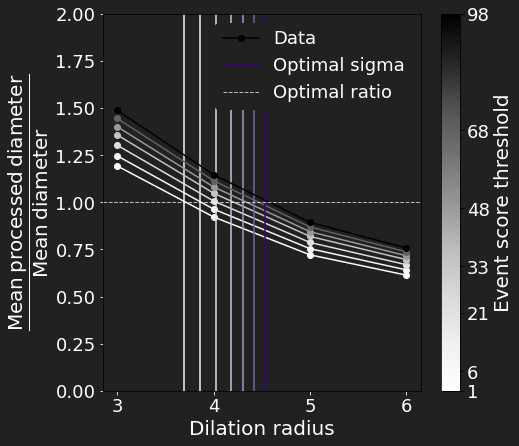

In [196]:
cmap_scatter = plt.cm.ScalarMappable(cmap='Greys', norm=Normalize(threshold.min(), threshold.max()))
cmap_linear_fit = plt.cm.ScalarMappable(cmap='Reds', norm=Normalize(threshold.min(), threshold.max()))
cmap_optimal_sigma = plt.cm.ScalarMappable(cmap='Purples', norm=Normalize(threshold.min(), threshold.max()))

t_step = (threshold[1]-threshold[0])/nb_thresholds

framecolor = (0.13, 0.13, 0.12, 1)

title = 'diam_ratio_vs_sigma'
filename = base_dir+'Figures/'+title+'.png'
print(filename)

fig, ax = plt.subplots(figsize=(7, 6))
fig.set_facecolor(framecolor)
ax.set_facecolor(framecolor)

#Linear fit
for i in range(nb_thresholds):
  t_weight = threshold[i]/threshold[-1] #Defines color from cmap
  x = np.round(sigmas*2)
  scatter = ax.plot(x, diam_ratio[:, i], 'o-', color=cmap_scatter.get_cmap()(t_weight))[0]
  optimal_sigma_line = ax.axvline(optimal_sigma[i]*2, ls='-', color=cmap_optimal_sigma.get_cmap()(t_weight))
  
cbar = fig.colorbar(cmap_scatter, ax=ax)
ticklabels = np.round(threshold, 1)
cbar.set_ticks(threshold)
cbar.ax.set_yticklabels(ticklabels, color='white')
cbar.set_label('Event score threshold', color='white')

#Optimal ratio=1  
ax.axhline(1, ls='--', color='white', lw=1, alpha=0.7, label='Optimal ratio')

#Optimal sigma
#markerline, stemlines, baseline = ax.stem(optimal_sigma, np.ones_like(optimal_sigma)*diam_ratio.min(), markerfmt='none', basefmt='none')
#plt.setp(stemlines, color=cmap_scatter.get_cmap()(threshold/threshold[-1]), linewidth=2)

ax.tick_params(axis='x', colors='white')
ax.tick_params(axis='y', colors='white')

scatter.set_label('Data')
line.set_label('Linear fit')
optimal_sigma_line.set_label('Optimal sigma')

ax.set_xlabel(r'Dilation radius', color='white')
ax.set_ylabel(r'$\dfrac{\mathrm{Mean\hspace{0.2}processed\hspace{0.2}diameter}}{\mathrm{Mean\hspace{0.2}diameter}}$', color='white')

ax.set_ylim([0, 2])
legend = ax.legend(facecolor=framecolor, framealpha=1, labelcolor='white')
frame = legend.get_frame()
frame.set_color(framecolor)
fig.tight_layout(pad=0)

#plt.show()
plt.savefig(filename, transparent=True)

##### Interpolated $\sigma_{opt}$ vs. Probability threshold

D:/Santi/Figures/optimal_sigma_vs_threshold.png


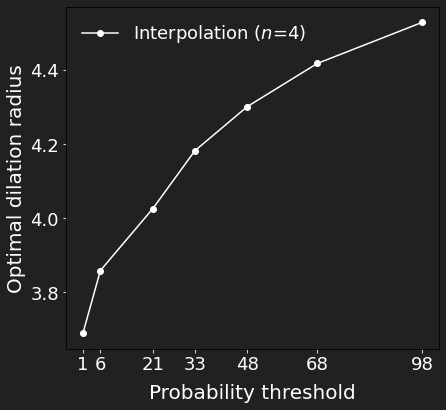

In [197]:
title = 'optimal_sigma_vs_threshold'
filename = base_dir+'Figures/'+title+'.png'
print(filename)

framecolor = (0.13, 0.13, 0.13, 1)

fig, ax = plt.subplots(figsize=(6, 5.5))
fig.set_facecolor(framecolor)
ax.set_facecolor(framecolor)
ax.plot(threshold, optimal_sigma*2, 'o-', color='white', label=r'Interpolation ($n$=%i)'%nb_sigmas)
#ax.plot(threshold, np.dot(fit_params, [threshold**2, threshold, 1]) , color='tab:red', label='Cuadratic approximation')

ax.set_xticks(threshold)
ax.set_xticklabels(threshold.round(1))

ax.set_xlabel('Probability threshold', color='white', labelpad=10)
ax.set_ylabel(r'Optimal dilation radius', color='white')

ax.tick_params(axis='x', colors='white')
ax.tick_params(axis='y', colors='white')

legend = ax.legend(facecolor=framecolor, framealpha=1, labelcolor='white')
frame = legend.get_frame()
frame.set_color(framecolor)
fig.tight_layout(pad=0)

#plt.show()
plt.savefig(filename)

#### Results: filtered events using optimal sigma for each threshold

In [198]:
#Outputs
output_data = util.load_h5(data_path, 'Proc')
print('Outputs:', output_data.shape)

optimal_sigma = util.load_pkl(data_path, 'max_optimal_sigma')

threshold = util.load_pkl(data_path, 'max_intensity_threshold')


for s, t in zip(optimal_sigma, threshold):
  print('\n\nSigma: %.1f | Threshold: %i'%(s, t))
  print('    Prepare stack...')
  proc_output_data, fission_props = preprocessing.prepareStack(output_data, sigma=s, threshold=t)
  print('    Segment fissions...')
  labels = preprocessing.segmentFissionsStack(output_data*segmentation.clear_border(output_data>0), fission_props, sigma=s/10)
  print('    Segment processed fissions...')
  proc_labels = preprocessing.segmentFissionsStack(proc_output_data, fission_props)
  print('    Analyze processed fissions...')
  proc_fission_props = preprocessing.analyzeFissionsStack(proc_labels, proc_output_data)
  
  util.save_h5(proc_output_data, data_path, 'WatProc_s%.1f_t%i'%(s, t))
  util.save_h5(labels, data_path, 'labels_s%.1f_t%i'%(s, t))
  util.save_h5(proc_labels, data_path, 'proc_labels_s%.1f_t%i'%(s, t))
  util.save_pkl(fission_props, data_path, 'fission_props_s%.1f_t%i'%(s, t))
  util.save_pkl(proc_fission_props, data_path, 'proc_fission_props_s%.1f_t%i'%(s, t))


Loading D:/Santi/Data/Proc.h5
Converting to array
Outputs: (37000, 128, 128)

Loading D:/Santi/Data/max_optimal_sigma

Loading D:/Santi/Data/max_intensity_threshold


Sigma: 1.8 | Threshold: 1
    Prepare stack...


  0%|                                                          | 40/37000 [00:00<04:53, 126.10it/s]C:\Users\snrodrig\Documents\GitHub\MitoSplit-Net\mitosplit-net\preprocessing.py:115: UserWarning: Only one label was provided to `remove_small_objects`. Did you mean to use a boolean array?
  labels = morphology.remove_small_objects(labels, 9) #Remove too small objects
100%|███████████████████████████████████████████████████████| 37000/37000 [03:29<00:00, 176.74it/s]


    Segment fissions...


100%|███████████████████████████████████████████████████████| 37000/37000 [00:56<00:00, 651.22it/s]


    Segment processed fissions...


100%|███████████████████████████████████████████████████████| 37000/37000 [00:48<00:00, 765.14it/s]


    Analyze processed fissions...


100%|██████████████████████████████████████████████████████| 37000/37000 [00:10<00:00, 3431.65it/s]



Saving D:/Santi/Data/WatProc_s1.8_t1.h5
Done.

Saving D:/Santi/Data/labels_s1.8_t1.h5
Done.

Saving D:/Santi/Data/proc_labels_s1.8_t1.h5
Done.

Saving D:/Santi/Data/fission_props_s1.8_t1
Done.

Saving D:/Santi/Data/proc_fission_props_s1.8_t1
Done.


Sigma: 1.9 | Threshold: 6
    Prepare stack...


100%|███████████████████████████████████████████████████████| 37000/37000 [03:12<00:00, 191.95it/s]


    Segment fissions...


100%|███████████████████████████████████████████████████████| 37000/37000 [00:51<00:00, 717.22it/s]


    Segment processed fissions...


100%|███████████████████████████████████████████████████████| 37000/37000 [00:45<00:00, 810.30it/s]


    Analyze processed fissions...


100%|██████████████████████████████████████████████████████| 37000/37000 [00:09<00:00, 3770.62it/s]



Saving D:/Santi/Data/WatProc_s1.9_t6.h5
Done.

Saving D:/Santi/Data/labels_s1.9_t6.h5
Done.

Saving D:/Santi/Data/proc_labels_s1.9_t6.h5
Done.

Saving D:/Santi/Data/fission_props_s1.9_t6
Done.

Saving D:/Santi/Data/proc_fission_props_s1.9_t6
Done.


Sigma: 2.0 | Threshold: 21
    Prepare stack...


100%|███████████████████████████████████████████████████████| 37000/37000 [03:07<00:00, 197.76it/s]


    Segment fissions...


100%|███████████████████████████████████████████████████████| 37000/37000 [00:46<00:00, 804.07it/s]


    Segment processed fissions...


100%|███████████████████████████████████████████████████████| 37000/37000 [00:40<00:00, 916.33it/s]


    Analyze processed fissions...


100%|██████████████████████████████████████████████████████| 37000/37000 [00:08<00:00, 4344.87it/s]



Saving D:/Santi/Data/WatProc_s2.0_t21.h5
Done.

Saving D:/Santi/Data/labels_s2.0_t21.h5
Done.

Saving D:/Santi/Data/proc_labels_s2.0_t21.h5
Done.

Saving D:/Santi/Data/fission_props_s2.0_t21
Done.

Saving D:/Santi/Data/proc_fission_props_s2.0_t21
Done.


Sigma: 2.1 | Threshold: 33
    Prepare stack...


100%|███████████████████████████████████████████████████████| 37000/37000 [03:01<00:00, 203.98it/s]


    Segment fissions...


100%|███████████████████████████████████████████████████████| 37000/37000 [00:39<00:00, 929.06it/s]


    Segment processed fissions...


100%|██████████████████████████████████████████████████████| 37000/37000 [00:35<00:00, 1055.79it/s]


    Analyze processed fissions...


100%|██████████████████████████████████████████████████████| 37000/37000 [00:07<00:00, 5088.33it/s]



Saving D:/Santi/Data/WatProc_s2.1_t33.h5
Done.

Saving D:/Santi/Data/labels_s2.1_t33.h5
Done.

Saving D:/Santi/Data/proc_labels_s2.1_t33.h5
Done.

Saving D:/Santi/Data/fission_props_s2.1_t33
Done.

Saving D:/Santi/Data/proc_fission_props_s2.1_t33
Done.


Sigma: 2.2 | Threshold: 48
    Prepare stack...


100%|███████████████████████████████████████████████████████| 37000/37000 [02:55<00:00, 211.02it/s]


    Segment fissions...


100%|██████████████████████████████████████████████████████| 37000/37000 [00:34<00:00, 1085.72it/s]


    Segment processed fissions...


100%|██████████████████████████████████████████████████████| 37000/37000 [00:30<00:00, 1232.52it/s]


    Analyze processed fissions...


100%|██████████████████████████████████████████████████████| 37000/37000 [00:06<00:00, 6010.04it/s]



Saving D:/Santi/Data/WatProc_s2.2_t48.h5
Done.

Saving D:/Santi/Data/labels_s2.2_t48.h5
Done.

Saving D:/Santi/Data/proc_labels_s2.2_t48.h5
Done.

Saving D:/Santi/Data/fission_props_s2.2_t48
Done.

Saving D:/Santi/Data/proc_fission_props_s2.2_t48
Done.


Sigma: 2.2 | Threshold: 68
    Prepare stack...


100%|███████████████████████████████████████████████████████| 37000/37000 [02:50<00:00, 217.54it/s]


    Segment fissions...


100%|██████████████████████████████████████████████████████| 37000/37000 [00:28<00:00, 1312.47it/s]


    Segment processed fissions...


100%|██████████████████████████████████████████████████████| 37000/37000 [00:24<00:00, 1498.46it/s]


    Analyze processed fissions...


100%|██████████████████████████████████████████████████████| 37000/37000 [00:05<00:00, 7285.07it/s]



Saving D:/Santi/Data/WatProc_s2.2_t68.h5
Done.

Saving D:/Santi/Data/labels_s2.2_t68.h5
Done.

Saving D:/Santi/Data/proc_labels_s2.2_t68.h5
Done.

Saving D:/Santi/Data/fission_props_s2.2_t68
Done.

Saving D:/Santi/Data/proc_fission_props_s2.2_t68
Done.


Sigma: 2.3 | Threshold: 98
    Prepare stack...


100%|███████████████████████████████████████████████████████| 37000/37000 [02:48<00:00, 219.09it/s]


    Segment fissions...


100%|██████████████████████████████████████████████████████| 37000/37000 [00:21<00:00, 1683.43it/s]


    Segment processed fissions...


100%|██████████████████████████████████████████████████████| 37000/37000 [00:19<00:00, 1918.74it/s]


    Analyze processed fissions...


100%|██████████████████████████████████████████████████████| 37000/37000 [00:04<00:00, 9074.18it/s]



Saving D:/Santi/Data/WatProc_s2.3_t98.h5
Done.

Saving D:/Santi/Data/labels_s2.3_t98.h5
Done.

Saving D:/Santi/Data/proc_labels_s2.3_t98.h5
Done.

Saving D:/Santi/Data/fission_props_s2.3_t98
Done.

Saving D:/Santi/Data/proc_fission_props_s2.3_t98
Done.


# Spatiotemporal fission filter

Previously, we applied a temporal median filter to the max event score per frame to reduce the amount of false positives (mitochondria cannot divide instantaneously). However, this strategy does not take into account the spatial correlation in the probability map of divisions, as high event scores in consecutive frames might correspond to different fissions. To make the model consider spatiotemporal correlations, we filtered the GT output by applying a temporal median filter of the max event score per fission site. To track each fission site, we used the labels obtained with the Distance Watershed algorithm (see Section "GT preprocessing").

## Complete pipeline applied to processed GT with $\sigma=2.2$ and event score threshold = 48

### Find centroids of overlapping ROIs

In [34]:
sigma = 2.2
threshold = 48
fission_props = util.load_pkl(data_path, 'proc_fission_props_s%.1f_t%i'%(sigma, threshold))
T = preprocessing.track(fission_props)


Loading D:/Santi/Data/proc_fission_props_s2.2_t48


<ipython-input-4-a101bde582b3>:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ticks = np.linspace(0, num_frames, 5, endpoint=True, dtype=np.int)


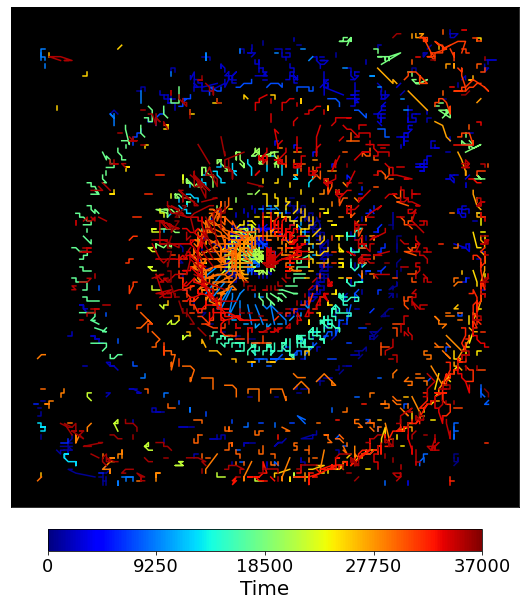

In [4]:
num_frames = len(fission_props)
norm = Normalize(vmin=0, vmax=num_frames)
cmap = plt.cm.jet
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
ticks = np.linspace(0, num_frames, 5, endpoint=True, dtype=np.int)

fig, ax = plt.subplots(figsize=(10, 10))
ax.set_facecolor('black')
for t, x in T:
  ax.plot(x[:, 1], x[:, 0], color=cmap(norm(t[0])))

ax.set(xticks=[], yticks=[])
fig.gca().invert_yaxis()

ax.set_aspect('equal')
cb = fig.colorbar(sm, ax=ax, ticks=ticks, fraction=0.04, pad=0.04, orientation='horizontal')
cb.set_ticklabels(ticks)
cb.set_label('Time')
plt.show()

### Get labels from centroids and calculate maximum event score per fission

In [5]:
output = util.load_h5(data_path, 'WatProc_s%.1f_t%i'%(sigma, threshold))
print('Output:', output.shape)

labels = util.load_h5(data_path, 'proc_labels_s%.1f_t%i'%(sigma, threshold))
print('Labels:', labels.shape)


Loading D:/Santi/Data/WatProc_s2.2_t48.h5
Converting to array
Output: (37000, 128, 128)

Loading D:/Santi/Data/proc_labels_s2.2_t48.h5
Converting to array
Labels: (37000, 128, 128)


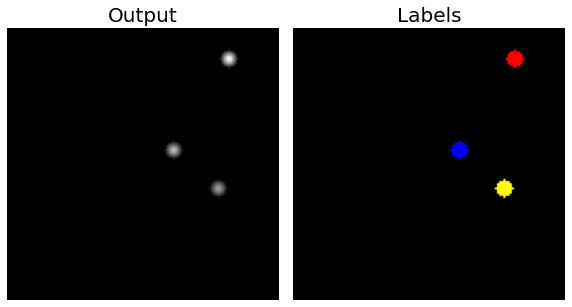

In [6]:
frame = 305
plotting.plot_comparison(output[frame], label2rgb(labels[frame], bg_label=0), labels=['Output', 'Labels'])
plt.show()

In [6]:
time, track_labels, event_score = preprocessing.get_event_score(output, labels, T)

#Signal smoothing
wsize = 5

event_score_gaussian = [ndi.gaussian_filter(m, wsize, mode='nearest') for m in event_score]

#threshold = int(np.percentile([np.mean(score) for score in event_score_gaussian], 5))
threshold = filters.threshold_multiotsu(np.array([np.mean(score) for score in event_score_gaussian]))[0]

temporal_filter = [score_gaussian>=threshold for score_gaussian in event_score_gaussian]

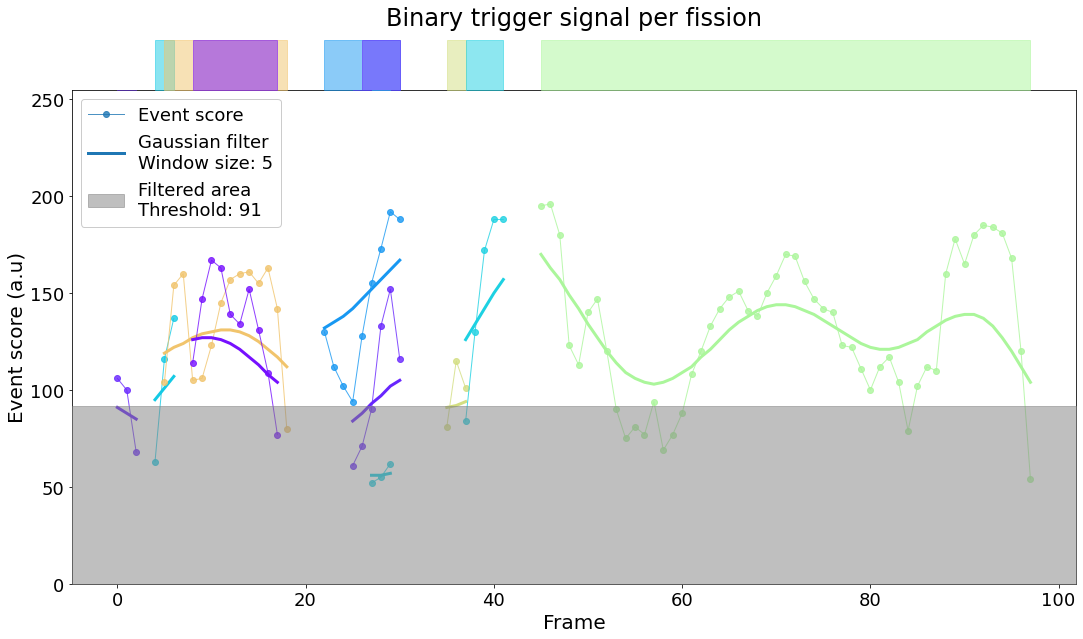

In [33]:
cmap = plt.cm.rainbow
yfill_lim = [0, 1]

score_plot_kwargs = dict(marker='o', lw=1, alpha=0.8)
score_gaussian_plot_kwargs = dict(lw=3)
threshold_plot_kwargs = dict(color='gray', alpha=0.5)
np.random.seed(seed=21)

low_id = 0
high_id = low_id + 10

fig = plt.figure(figsize=(18, 10))
gs = fig.add_gridspec(2, 1, height_ratios=[1, 10], hspace=0)

ax = fig.add_subplot(gs[1])
ax_filter = fig.add_subplot(gs[0], sharex=ax)

for t, score, score_gaussian, trigger_signal in zip(time[low_id:high_id], event_score[low_id:high_id], event_score_gaussian[low_id:high_id], temporal_filter[low_id:high_id]):
  rand_num = np.random.uniform(0, 1)
  color = cmap(rand_num)
 
  ax.plot(t, score, color=color, **score_plot_kwargs)
  ax.plot(t, score_gaussian, color=color, **score_gaussian_plot_kwargs)
  
  ax_filter.fill_between(t, 0, trigger_signal, step='pre', color=color, alpha=0.5)

ax_filter.axis('off')
ax_filter.set_ylim(yfill_lim)
ax_filter.set_title('Binary trigger signal per fission', size=24, pad=15)

xlim = ax.get_xlim()
ax.fill_between(xlim, 0, threshold, **threshold_plot_kwargs, zorder=10)
ax.set(xlabel='Frame', ylabel='Event score (a.u)', xlim=xlim, ylim=[0, 255])
ax.legend([plt.Line2D([], [], **score_plot_kwargs), 
           plt.Line2D([], [], **score_gaussian_plot_kwargs), 
           ax.fill_between(xlim, 0, 0, **threshold_plot_kwargs)], 
         ['Event score', 'Gaussian filter\nWindow size: %i'%wsize, 'Filtered area\nThreshold: %i'%threshold], framealpha=1).set_zorder(20)
plt.show()

### Apply temporal filter to the signal of each fission site and generate a new output dataset

In [12]:
metadata1 = 's2.2_t48'
metadata2 = 'w%i_gt%i'%(wsize, threshold)

#Thresholding
spatemp_output, spatemp_labels = preprocessing.selFissions(output, labels, time, track_labels, event_score_gaussian, threshold=threshold)
util.save_h5(spatemp_output, data_path, 'spatemp_WatProc_' + metadata1 + '_' + metadata2)
util.save_h5(spatemp_labels, data_path, 'spatemp_proc_labels_' + metadata1 + '_' + metadata2)
del output, labels, spatemp_output, spatemp_labels


Saving D:/Santi/Data/spatemp_WatProc_s2.2_t48_w5_gt91.h5
Done.

Saving D:/Santi/Data/spatemp_proc_labels_s2.2_t48_w5_gt91.h5
Done.

Saving D:/Santi/Data/der_spatemp_WatProc_s2.2_t48_w5_gt91.h5
Done.

Saving D:/Santi/Data/der_spatemp_proc_labels_s2.2_t48_w5_gt91.h5
Done.


### Comparison between original and spatiotemporally filtered GT

In [4]:
input_data = util.load_h5(data_path, 'Mito')
print('Input:', input_data.shape)


Loading D:/Santi/Data/Mito.h5
Converting to array
Input: (37000, 128, 128)


In [5]:
metadata1 = 's2.2_t48'
metadata2 = 'w5_gt91'

output = util.load_h5(data_path, 'WatProc_' + metadata1)
print('Gaussian Output:', output.shape)

spatemp_output = util.load_h5(data_path, 'spatemp_WatProc_' + metadata1 + '_' + metadata2)
print('spatemp_output:', spatemp_output.shape)


Loading D:/Santi/Data/WatProc_s2.2_t48.h5
Converting to array
Gaussian Output: (37000, 128, 128)

Loading D:/Santi/Data/spatemp_WatProc_s2.2_t48_w5_gt91.h5
Converting to array
spatemp_output: (37000, 128, 128)


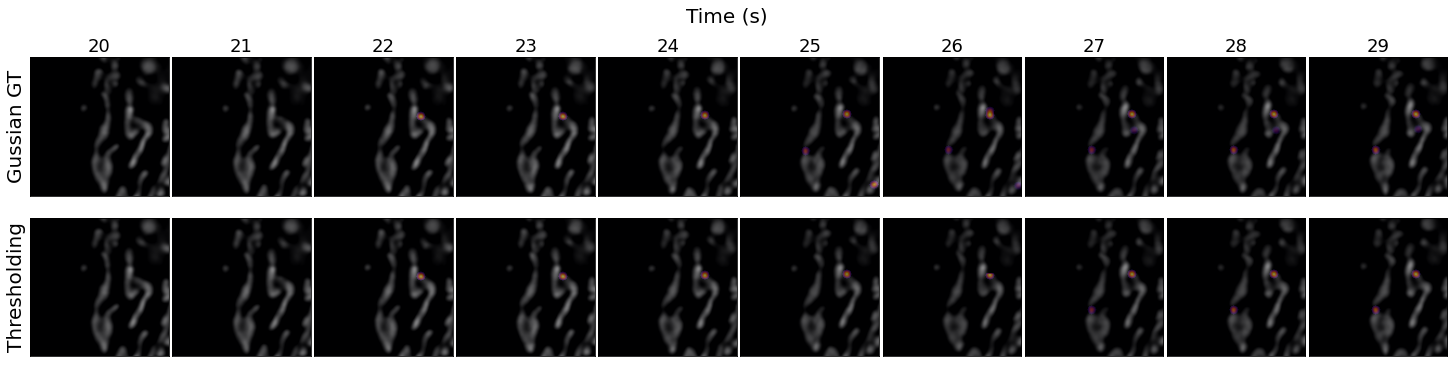

In [7]:
initial_frame = 20
final_frame = 30
duration = final_frame-initial_frame

vmax = 255
norm_mito = Normalize(vmin=0, vmax=vmax)
norm_event = Normalize(vmin=0, vmax=1)

cmap_mito = plt.cm.ScalarMappable(cmap='gray', norm=norm_event).get_cmap()
cmap_event = plt.cm.ScalarMappable(cmap='inferno', norm=norm_event).get_cmap()
cmap = [cmap_mito, cmap_event]

title = ['Gussian GT', 'Thresholding']


fig, axes = plt.subplots(2, duration, figsize=(20, 5))
fig.suptitle('Time (s)', size=20)
for i, img_input, img_gauss, img_thr in zip(range(duration), input_data[initial_frame:final_frame], output[initial_frame:final_frame], 
                                                               spatemp_output[initial_frame:final_frame]):
  
  plotting.plot_merge(img_input, img_gauss, ax=axes[0, i], title='', cmap=cmap)
  axes[0, i].set_title(i+initial_frame, size=18)

  plotting.plot_merge(img_input, img_thr, ax=axes[1, i], title='', cmap=cmap)

  

for ax in axes.flatten():
  ax.set(xticks=[], yticks=[])
  
for i, t in enumerate(title):
  axes[i, 0].set_ylabel(t)
  
  
fig.tight_layout(pad=0)
fig.subplots_adjust(top=0.85, hspace=0.1)
plt.show()

## Generate all training datasets

In [3]:
event_score_thresholds = util.load_pkl(data_path, 'max_intensity_threshold')
optimal_sigma = util.load_pkl(data_path, 'max_optimal_sigma')

event_score_gaussian_thresholds = []

#Window size for temporal smoothing
wsize = 5


for sigma, threshold in zip(optimal_sigma, event_score_thresholds):
  print('Gaussian dilation sigma: %.1f\nEvent score threshold: %i'%(sigma, threshold))
  
  metadata1 = 's%.1f_t%i'%(sigma, threshold)
  fission_props = util.load_pkl(data_path, 'proc_fission_props_'+metadata1)
  T = preprocessing.track(fission_props)

  output = util.load_h5(data_path, 'WatProc_'+metadata1)
  print('Output:', output.shape)
  labels = util.load_h5(data_path, 'proc_labels_'+metadata1)
  print('Labels:', labels.shape)

  #Calculate event score per fisison
  time, track_labels, event_score = preprocessing.get_event_score(output, labels, T)
  event_score_gaussian = [ndi.gaussian_filter(m, wsize, mode='nearest') for m in event_score]

  #Calculate new event score threshold to filter individual fissions per frame
  event_score_gaussian_thresholds += [filters.threshold_multiotsu(np.array([np.mean(score) for score in event_score_gaussian]))[0]]
  metadata2 = 'w%i_gt%i'%(wsize, event_score_gaussian_thresholds[-1])
  
  #Thresholding
  spatemp_output, spatemp_labels = preprocessing.selFissions(output, labels, time, track_labels, event_score_gaussian, 
                                                             threshold=event_score_gaussian_thresholds[-1])
  util.save_h5(spatemp_output, data_path, 'spatemp_WatProc_' + metadata1 + '_' + metadata2)
  util.save_h5(spatemp_labels, data_path, 'spatemp_proc_labels_' + metadata1 + '_' + metadata2)
  del output, labels, spatemp_output, spatemp_labels
  
util.save_pkl(np.array(event_score_gaussian_thresholds), data_path, 'event_score_gaussian_thresholds')


Loading D:/Santi/Data/max_intensity_threshold

Loading D:/Santi/Data/max_optimal_sigma
Gaussian dilation sigma: 1.8
Event score threshold: 1

Loading D:/Santi/Data/proc_fission_props_s1.8_t1

Loading D:/Santi/Data/WatProc_s1.8_t1.h5
Converting to array
Output: (37000, 128, 128)

Loading D:/Santi/Data/proc_labels_s1.8_t1.h5
Converting to array
Labels: (37000, 128, 128)

Saving D:/Santi/Data/spatemp_WatProc_s1.8_t1_w5_gt38.h5
Done.

Saving D:/Santi/Data/spatemp_proc_labels_s1.8_t1_w5_gt38.h5
Done.
Gaussian dilation sigma: 1.9
Event score threshold: 6

Loading D:/Santi/Data/proc_fission_props_s1.9_t6

Loading D:/Santi/Data/WatProc_s1.9_t6.h5
Converting to array
Output: (37000, 128, 128)

Loading D:/Santi/Data/proc_labels_s1.9_t6.h5
Converting to array
Labels: (37000, 128, 128)

Saving D:/Santi/Data/spatemp_WatProc_s1.9_t6_w5_gt49.h5
Done.

Saving D:/Santi/Data/spatemp_proc_labels_s1.9_t6_w5_gt49.h5
Done.
Gaussian dilation sigma: 2.0
Event score threshold: 21

Loading D:/Santi/Data/proc_f